In [172]:
# Data wrangling tools
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Statistical Tools
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

import os

In [173]:
mortdf = pd.read_csv(r"C:\Users\Documents\NEU Study\Second year\Second term\Econometrics\Project\death .csv", encoding = "latin1")
incddf = pd.read_csv(r"C:\Users\Documents\NEU Study\Second year\Second term\Econometrics\Project\incd.csv", encoding = "latin1")

In [174]:
incddf.rename(columns= {' FIPS': 'FIPS'}, inplace= True)

# 1. Acquire and Prepare Data    
### Cancer Incidence & Mortality Data from American Community Survey (ACS)

In [175]:
# Retrieve the cancer data
mortdf = mortdf[mortdf.FIPS.notnull()]
incddf = incddf[incddf.FIPS.notnull()]

mortdf['FIPS'] = mortdf.FIPS.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')

incddf['FIPS'] = incddf.FIPS.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')

incddf.drop(incddf.columns[[0,3,4,7,8,9]].values, axis=1, inplace=True)
mortdf.drop(mortdf.columns[[0,2,4,5,7,8,9,10]], axis=1, inplace=True)

incddf.rename(columns={incddf.columns[1]:'Incidence_Rate',
                       incddf.columns[2]:'Avg_Ann_Incidence'}, inplace=True)
mortdf.rename(columns={mortdf.columns[1]:'Mortality_Rate',
                       mortdf.columns[2]:'Avg_Ann_Deaths'}, inplace=True)

In [176]:
mortdf.head()

,FIPS,Mortality_Rate,Avg_Ann_Deaths
0,00000,46,"157,376"
1,21193,125.6,43
2,21197,125.3,18
3,02185,124.9,5
4,21189,118.5,8


In [177]:
incddf.head()

,FIPS,Incidence_Rate,Avg_Ann_Incidence,Recent Trend
0,00000,62.4,214614,falling
1,01001,74.9,43,stable
2,01003,66.9,170,stable
3,01005,74.6,25,stable
4,01007,86.4,23,stable


### Census Data     
Now that we've acquired lung cancer incidence and mortality data, our goal is to include additional data that we can use to build a model. We want interesting variables which explain (are correlated with) incidence or mortality. A couple things to note:   
1. To join with incidence and mortality, we need data that are indexed by US County.
2. We're looking for variables which explain (are correlated with) incidence and mortality.
3. We want interesting (meaningful and relevant) variables. And we choose:  
  * Poverty
  * Median Income
  * Health Insurance

#### A. Poverty Data
##### Poverty Status in the Past 12 Months by Sex by Age for Population For Whom Poverty Status Is Determined

| Variable Name       | Description                                                                                            |
|---------------------|--------------------------------------------------------------------------------------------------------|
| B17001_002          | Percentage of Income in the past 12 months below poverty level |
| B17001_003          | Percentage of Income in the past 12 months below poverty level, Male |
| B17001_017          | Percentage of Income in the past 12 months below poverty level, Female |


In [178]:
# Directory where your downloaded CSV files are stored
csv_directory = r"C:\Users\Documents\NEU Study\Second year\Second term\Econometrics\Project\poverty"
# List to store table names
tables = []

# Iterate over files in the directory
for filename in os.listdir(csv_directory):
    # Check if the file is a CSV file
    if filename.endswith(".csv"):
        # Extract the table name from the filename
        table_name = os.path.splitext(filename)[0]
        tables.append(table_name)

# Filter out Puerto Rico
tables_by_state = [table for table in tables if table.lower() != 'pr' and len(table) == 2]

# Load datasets into a dictionary
pov = {}
for table_name in tables_by_state:
    file_path = os.path.join(csv_directory, f"{table_name}.csv")
    pov[table_name] = pd.read_csv(file_path)

for key in pov:
    pov[key] = pov[key][pov[key]['SummaryLevel'] == 50]
    pov[key] = pov[key][['State', 'StateFIPS', 'CountyFIPS', 'AreaName', 'B17001_002', 'B17001_003', 'B17001_017']]

# Now you can access each dataset using its table name as a key in the pov dictionary

C:\Users\Tran Duy Anh\AppData\Local\Temp\ipykernel_33532\3390500294.py:21: DtypeWarning: Columns (744,745,746,1178,1179,1180,1181,1182) have mixed types. Specify dtype option on import or set low_memory=False.
  pov[table_name] = pd.read_csv(file_path)
C:\Users\Tran Duy Anh\AppData\Local\Temp\ipykernel_33532\3390500294.py:21: DtypeWarning: Columns (744,745,746,1178,1179,1180,1181,1182) have mixed types. Specify dtype option on import or set low_memory=False.
  pov[table_name] = pd.read_csv(file_path)
C:\Users\Tran Duy Anh\AppData\Local\Temp\ipykernel_33532\3390500294.py:21: DtypeWarning: Columns (744,745,746,1178,1179,1180,1181,1182) have mixed types. Specify dtype option on import or set low_memory=False.
  pov[table_name] = pd.read_csv(file_path)


In [179]:
povdf = pd.DataFrame()

# Call the data for each state and concatenate
for key in pov:
    povdf = pd.concat([povdf, pov[key]], ignore_index=True)


# Add leading zeros to the state and county FIPS codes
povdf['StateFIPS'] = povdf['StateFIPS'].astype(str)
povdf['CountyFIPS'] = povdf['CountyFIPS'].astype(int)
povdf['CountyFIPS'] = povdf['CountyFIPS'].astype(str)

# Add leading zeros to the state and county FIPS codes
povdf['StateFIPS'] = povdf['StateFIPS'].str.pad(2, 'left', '0')
povdf['CountyFIPS'] = povdf['CountyFIPS'].str.pad(3, 'left', '0')

povdf.rename(columns={'B17001_002':'All_Poverty', 'B17001_003':'M_Poverty', 'B17001_017':'F_Poverty'},
             inplace=True)

In [180]:
povdf.head()

,State,StateFIPS,CountyFIPS,AreaName,All_Poverty,M_Poverty,F_Poverty
0,AK,02,013,"Aleutians East Borough, Alaska",553,334,219
1,AK,02,016,"Aleutians West Census Area, Alaska",499,273,226
2,AK,02,020,"Anchorage Municipality, Alaska",23914,10698,13216
3,AK,02,050,"Bethel Census Area, Alaska",4364,2199,2165
4,AK,02,060,"Bristol Bay Borough, Alaska",69,33,36


#### B. Income Data
##### Median Household Income in the Past 12 Months (in 2015 Inflation-Adjusted Dollars)

|      Variable Name      |                                        Description                                         |
|-------------------------|-------------------------------------------------------------------------------------------|
|       B19013_001        | For Households |
|       B19013A_001       | (White Alone Householder) For Households With A Householder Who Is White Alone |
|       B19013B_001       | (Black or African American Alone Householder) For Households With A Householder Who Is Black Or African American Alone |
|       B19013C_001       | (American Indian and Alaska Native Alone Householder) For Households With A Householder Who Is American Indian And Alaska Native Alone |
|       B19013D_001       | (Asian Alone Householder) For Households With A Householder Who Is Asian Alone |
|       B19013I_001       | (Hispanic or Latino Householder) For Households With A Householder Who Is Hispanic Or Latino |


In [181]:
# Directory where your downloaded CSV files are stored
csv_directory = r"C:\Users\Documents\NEU Study\Second year\Second term\Econometrics\Project\income"
# List to store table names
tables = []

# Iterate over files in the directory
for filename in os.listdir(csv_directory):
    # Check if the file is a CSV file
    if filename.endswith(".csv"):
        # Extract the table name from the filename
        table_name = os.path.splitext(filename)[0]
        tables.append(table_name)

# Filter out Puerto Rico
tables_by_state = [table for table in tables if table.lower() != 'pr' and len(table) == 2]

# Load datasets into a dictionary
income = {}
for table_name in tables_by_state:
    file_path = os.path.join(csv_directory, f"{table_name}.csv")
    income[table_name] = pd.read_csv(file_path)

for key in income:
    income[key] = income[key][income[key]['SummaryLevel'] == 50]
    income[key] = income[key][['StateFIPS', 'CountyFIPS', 'B19013_001', 'B19013A_001', 'B19013B_001', 'B19013C_001', 'B19013D_001', 'B19013I_001']]

# Now you can access each dataset using its table name as a key in the pov dictionary

C:\Users\Tran Duy Anh\AppData\Local\Temp\ipykernel_33532\2153994505.py:21: DtypeWarning: Columns (197,902,951,952,953,954,955,956,957,958,959,960,961,962,1383,1393) have mixed types. Specify dtype option on import or set low_memory=False.
  income[table_name] = pd.read_csv(file_path)
C:\Users\Tran Duy Anh\AppData\Local\Temp\ipykernel_33532\2153994505.py:21: DtypeWarning: Columns (198,205,906,937,938,941,963,1170,1171,1172,1174,1175,1179,1181,1182,1183,1184,1185,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1384,1391,1394,1401,1498) have mixed types. Specify dtype option on import or set low_memory=False.
  income[table_name] = pd.read_csv(file_path)
C:\Users\Tran Duy Anh\AppData\Local\Temp\ipykernel_33532\2153994505.py:21: DtypeWarning: Columns (179,180,181,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,897,898,899,900,901,902,903,904,905,906,937,938,93

In [182]:
incomedf = pd.DataFrame()

for key in income:
    incomedf = pd.concat([incomedf, income[key]], ignore_index=True)

# Add leading zeros to the state and county FIPS codes
incomedf['StateFIPS'] = incomedf['StateFIPS'].astype(str)
incomedf['CountyFIPS'] = incomedf['CountyFIPS'].astype(int)
incomedf['CountyFIPS'] = incomedf['CountyFIPS'].astype(str)

# Add leading zeros to the state and county FIPS codes
incomedf['StateFIPS'] = incomedf['StateFIPS'].str.pad(2, 'left', '0')
incomedf['CountyFIPS'] = incomedf['CountyFIPS'].str.pad(3, 'left', '0')


incomedf.rename(columns={'B19013_001':'Med_Income', 'B19013A_001':'Med_Income_White', 
                         'B19013B_001':'Med_Income_Black', 'B19013C_001':'Med_Income_Nat_Am',
                         'B19013D_001':'Med_Income_Asian', 'B19013I_001':'Hispanic'}, inplace=True)

In [183]:
incomedf.head()

,StateFIPS,CountyFIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic
0,02,013,61518,72639,31250,54750,62679,51250
1,02,016,84306,97321,93750,48750,81250,77500
2,02,020,78326,87235,50535,53935,63757,53926
3,02,050,51012,92647,73661,41594,110625,160114
4,02,060,79750,88000,.,63333,.,25625


#### C. Health Insurance Data
##### Health Insurance Coverage Status by Sex by Age for Civilian Noninstitutionalized Population

| Variable Name | Description                                                                                            |
|---------------|--------------------------------------------------------------------------------------------------------|
| B27001_004    | Male: Under 6 years: With health insurance coverage                                                    |
| B27001_005    | Male: Under 6 years: No health insurance coverage                                                       |
| B27001_007    | Male: 6 to 17 years: With health insurance coverage                                                     |
| B27001_008    | Male: 6 to 17 years: No health insurance coverage                                                        |
| B27001_010    | Male: 18 to 24 years: With health insurance coverage                                                    |
| B27001_011    | Male: 18 to 24 years: No health insurance coverage                                                       |
| B27001_013    | Male: 25 to 34 years: With health insurance coverage                                                    |
| B27001_014    | Male: 25 to 34 years: No health insurance coverage                                                       |
| B27001_016    | Male: 35 to 44 years: With health insurance coverage                                                    |
| B27001_017    | Male: 35 to 44 years: No health insurance coverage                                                       |
| B27001_019    | Male: 45 to 54 years: With health insurance coverage                                                    |
| B27001_020    | Male: 45 to 54 years: No health insurance coverage                                                       |
| B27001_022    | Male: 55 to 64 years: With health insurance coverage                                                    |
| B27001_023    | Male: 55 to 64 years: No health insurance coverage                                                       |
| B27001_025    | Male: 65 to 74 years: With health insurance coverage                                                    |
| B27001_026    | Male: 65 to 74 years: No health insurance coverage                                                       |
| B27001_028    | Male: 75 years and over: With health insurance coverage                                                  |
| B27001_029    | Male: 75 years and over: No health insurance coverage                                                     |
| B27001_032    | Female: Under 6 years: With health insurance coverage                                                   |
| B27001_033    | Female: Under 6 years: No health insurance coverage                                                      |
| B27001_035    | Female: 6 to 17 years: With health insurance coverage                                                    |
| B27001_036    | Female: 6 to 17 years: No health insurance coverage                                                       |
| B27001_038    | Female: 18 to 24 years: With health insurance coverage                                                   |
| B27001_039    | Female: 18 to 24 years: No health insurance coverage                                                      |
| B27001_041    | Female: 25 to 34 years: With health insurance coverage                                                   |
| B27001_042    | Female: 25 to 34 years: No health insurance coverage                                                      |
| B27001_044    | Female: 35 to 44 years: With health insurance coverage                                                   |
| B27001_045    | Female: 35 to 44 years: No health insurance coverage                                                      |
| B27001_047    | Female: 45 to 54 years: With health insurance coverage                                                   |
| B27001_048    | Female: 45 to 54 years: No health insurance coverage                                                      |
| B27001_050    | Female: 55 to 64 years: With health insurance coverage                                                   |
| B27001_051    | Female: 55 to 64 years: No health insurance coverage                                                      |
| B27001_053    | Female: 65 to 74 years: With health insurance coverage                                                   |
| B27001_054    | Female: 65 to 74 years: No health insurance coverage                                                      |
| B27001_056    | Female: 75 years and over: With health insurance coverage                                                 |
| B27001_057    | Female: 75 years and over: No health insurance coverage                                                    |


In [184]:
# Directory where your downloaded CSV files are stored
csv_directory = r"C:\Users\Documents\NEU Study\Second year\Second term\Econometrics\Project\health insurance"
# List to store table names
tables = []

# Iterate over files in the directory
for filename in os.listdir(csv_directory):
    # Check if the file is a CSV file
    if filename.endswith(".csv"):
        # Extract the table name from the filename
        table_name = os.path.splitext(filename)[0]
        tables.append(table_name)

# Filter out Puerto Rico
tables_by_state = [table for table in tables if table.lower() != 'pr' and len(table) == 2]

# Load datasets into a dictionary
health_insurance = {}
for table_name in tables_by_state:
    file_path = os.path.join(csv_directory, f"{table_name}.csv")
    health_insurance[table_name] = pd.read_csv(file_path)

for key in income:
    health_insurance[key] = health_insurance[key][health_insurance[key]['SummaryLevel'] == 50]
    health_insurance[key] = health_insurance[key][['StateFIPS', 'CountyFIPS', 'B27001_004', 'B27001_005', 'B27001_007', 'B27001_008', 'B27001_010', 'B27001_011', 'B27001_013', 'B27001_014', 'B27001_016', 'B27001_017', 'B27001_019', 'B27001_020', 'B27001_022', 'B27001_023', 'B27001_025', 'B27001_026', 'B27001_028', 'B27001_029', 'B27001_032', 'B27001_033', 'B27001_035', 'B27001_036', 'B27001_038', 'B27001_039', 'B27001_041', 'B27001_042', 'B27001_044', 'B27001_045', 'B27001_047', 'B27001_048', 'B27001_050', 'B27001_051', 'B27001_053', 'B27001_054', 'B27001_056', 'B27001_057']]

# Now you can access each dataset using its table name as a key in the pov dictionary

In [185]:
insurancedf = pd.DataFrame()

for key in health_insurance:
    insurancedf = pd.concat([insurancedf, health_insurance[key]], ignore_index=True)

# Add leading zeros to the state and county FIPS codes
insurancedf['StateFIPS'] = insurancedf['StateFIPS'].astype(str)
insurancedf['CountyFIPS'] = insurancedf['CountyFIPS'].astype(int)
insurancedf['CountyFIPS'] = insurancedf['CountyFIPS'].astype(str)

# Add leading zeros to the state and county FIPS codes
insurancedf['StateFIPS'] = insurancedf['StateFIPS'].str.pad(2, 'left', '0')
insurancedf['CountyFIPS'] = insurancedf['CountyFIPS'].str.pad(3, 'left', '0')

In [186]:
insurancedf.head()

,StateFIPS,CountyFIPS,B27001_004,B27001_005,B27001_007,B27001_008,B27001_010,B27001_011,B27001_013,B27001_014,...,B27001_044,B27001_045,B27001_047,B27001_048,B27001_050,B27001_051,B27001_053,B27001_054,B27001_056,B27001_057
0,02,013,57,20,91,62,51,212,90,246,...,68,55,168,134,59,117,48,9,25,0
1,02,016,111,28,279,61,260,102,335,219,...,231,99,266,76,169,116,72,12,17,0
2,02,020,12404,1513,21747,2957,12011,3967,17188,5650,...,15569,3050,16525,3482,15011,2310,8106,252,4829,29
3,02,050,1002,145,1951,204,460,511,666,597,...,736,224,625,281,501,251,372,6,197,0
4,02,060,32,4,71,16,39,13,36,30,...,53,9,63,13,49,14,13,0,16,0


In [187]:
# Columns representing males' health insurance statistics
males = ['`B27001_004`', '`B27001_005`', '`B27001_007`', '`B27001_008`',
           '`B27001_010`', '`B27001_011`', '`B27001_013`', '`B27001_014`',
           '`B27001_016`', '`B27001_017`', '`B27001_019`', '`B27001_020`',
           '`B27001_022`', '`B27001_023`', '`B27001_025`', '`B27001_026`',
           '`B27001_028`', '`B27001_029`']

# Females' health insurance statistics
females = ['`B27001_032`', '`B27001_033`', '`B27001_035`', '`B27001_036`', 
           '`B27001_038`', '`B27001_039`', '`B27001_041`', '`B27001_042`', 
           '`B27001_044`', '`B27001_045`', '`B27001_047`', '`B27001_048`', 
           '`B27001_050`', '`B27001_051`', '`B27001_053`', '`B27001_054`', 
           '`B27001_056`', '`B27001_057`']

# Separate the "with" and "without" health insurance columns
males_with = []
males_without = []
females_with = []
females_without = []

# Strip the backticks
for i, j in enumerate(males):
    if i % 2 == 0:
        males_with.append(j.replace('`', ''))
    else:
        males_without.append(j.replace('`', ''))
        
for i, j in enumerate(females):
    if i % 2 == 0:
        females_with.append(j.replace('`', ''))
    else:
        females_without.append(j.replace('`', ''))

# Create features that sum all the individual age group
clist = [males_with, males_without, females_with, females_without]
newcols = ['M_With', 'M_Without', 'F_With', 'F_Without'] 

for col in newcols:
    insurancedf[col] = 0

for i in males_with:
    insurancedf['M_With'] += insurancedf[i]  
for i in males_without:
    insurancedf['M_Without'] += insurancedf[i]
for i in females_with:
    insurancedf['F_With'] += insurancedf[i]
for i in females_without:
    insurancedf['F_Without'] += insurancedf[i]

insurancedf['All_With'] = insurancedf.M_With + insurancedf.F_With
insurancedf['All_Without'] = insurancedf.M_Without + insurancedf.F_Without


In [188]:
insurancedf.head()

,StateFIPS,CountyFIPS,B27001_004,B27001_005,B27001_007,B27001_008,B27001_010,B27001_011,B27001_013,B27001_014,...,B27001_053,B27001_054,B27001_056,B27001_057,M_With,M_Without,F_With,F_Without,All_With,All_Without
0,02,013,57,20,91,62,51,212,90,246,...,48,9,25,0,876,1317,566,540,1442,1857
1,02,016,111,28,279,61,260,102,335,219,...,72,12,17,0,2470,769,1707,564,4177,1333
2,02,020,12404,1513,21747,2957,12011,3967,17188,5650,...,8106,252,4829,29,120747,23245,122426,21393,243173,44638
3,02,050,1002,145,1951,204,460,511,666,597,...,372,6,197,0,6396,2708,6627,1774,13023,4482
4,02,060,32,4,71,16,39,13,36,30,...,13,0,16,0,419,124,349,67,768,191


In [189]:
# Remove all the individual age group variables
insurancedf.drop(insurancedf.columns[insurancedf.columns.str.contains('B27001')].values, axis=1, inplace=True)

### Merge DataFrames    
We're going to merge on the FIPS column. It's a 5-digit code. The first 2 digits are the 2-digit FIPS state code. The third, fourth, and fifth are the 3-digit FIPS county code.   
1. First, let's create a "FIPS" in each dataframe by concatenating the state and county codes.   
2. Then, let's check to make sure that they properly match up.

In [190]:
dfs = [povdf, incomedf, insurancedf, incddf, mortdf]

In [191]:
# Create FIPS features
for df in [povdf, incomedf, insurancedf]:
    df['FIPS'] = df.StateFIPS + df.CountyFIPS
    df.drop(['StateFIPS', 'CountyFIPS'], axis=1, inplace=True)

In [192]:
# Check to see if all the FIPS values are 5 digits in length
dfs = [povdf, incomedf, insurancedf, incddf, mortdf] # Our 5 dataframes to merge
for i, j in enumerate(dfs):
    lens = []
    for fips in j.FIPS.values:
        lens.append(len(fips))
    print(pd.Series(lens).value_counts(), '\n', '-'*10)    

5    3142
Name: count, dtype: int64 
 ----------
5    3142
Name: count, dtype: int64 
 ----------
5    3142
Name: count, dtype: int64 
 ----------
5    3141
Name: count, dtype: int64 
 ----------
5    3141
Name: count, dtype: int64 
 ----------


The FIPS column in each dataframe is formatted well and they match up. After that, we join them together into one large dataframe.

In [193]:
for i, j in enumerate(dfs):
    if i == 0:
        fulldf = j.copy()
    else:
        fulldf = fulldf.merge(j, how='inner', on='FIPS')

# 2. Exploratory Analysis (and continued data cleaning)

In [194]:
fulldf.shape

(3134, 23)

In [195]:
fulldf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,...,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent Trend,Mortality_Rate,Avg_Ann_Deaths
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518,72639,31250,54750,...,1317,566,540,1442,1857,*,3 or fewer,*,*,*
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306,97321,93750,48750,...,769,1707,564,4177,1333,*,3 or fewer,*,*,*
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326,87235,50535,53935,...,23245,122426,21393,243173,44638,61.5,131,stable,47.3,96
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012,92647,73661,41594,...,2708,6627,1774,13023,4482,62.7,6,stable,58.3,5
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750,88000,.,63333,...,124,349,67,768,191,*,3 or fewer,*,*,*


In [196]:
# Check for null values
for col in fulldf.columns:
    print((col, sum(fulldf[col].isnull())))

('State', 0)
('AreaName', 0)
('All_Poverty', 0)
('M_Poverty', 0)
('F_Poverty', 0)
('FIPS', 0)
('Med_Income', 1)
('Med_Income_White', 2)
('Med_Income_Black', 301)
('Med_Income_Nat_Am', 508)
('Med_Income_Asian', 438)
('Hispanic', 414)
('M_With', 0)
('M_Without', 0)
('F_With', 0)
('F_Without', 0)
('All_With', 0)
('All_Without', 0)
('Incidence_Rate', 0)
('Avg_Ann_Incidence', 0)
('Recent Trend', 0)
('Mortality_Rate', 0)
('Avg_Ann_Deaths', 0)


In [197]:
# Delete columns having null values, except for the Med_Income column
fulldf.drop(['Med_Income_White', 'Med_Income_Black', 'Med_Income_Nat_Am',
             'Med_Income_Asian', 'Hispanic'], axis=1, inplace=True)

In [198]:
# Fill the null value in Med_Income column with its median
fulldf['Med_Income'].fillna(fulldf['Med_Income'].median(), inplace= True)

In [199]:
fulldf['Med_Income'] = fulldf['Med_Income'].astype(float)

In [200]:
# Format all of numeric features as numeric objects
def get_types(col_name):
    ts = (pd.Series([type(i) for i in fulldf[col_name]]).value_counts())
    print("%s\n" % feature, ts, "\n", "-"*30)

for feature in fulldf.columns:
    get_types(feature)

State
 <class 'str'>    3134
Name: count, dtype: int64 
 ------------------------------
AreaName
 <class 'str'>    3134
Name: count, dtype: int64 
 ------------------------------
All_Poverty
 <class 'int'>    3134
Name: count, dtype: int64 
 ------------------------------
M_Poverty
 <class 'int'>    3134
Name: count, dtype: int64 
 ------------------------------
F_Poverty
 <class 'int'>    3134
Name: count, dtype: int64 
 ------------------------------
FIPS
 <class 'str'>    3134
Name: count, dtype: int64 
 ------------------------------
Med_Income
 <class 'float'>    3134
Name: count, dtype: int64 
 ------------------------------
M_With
 <class 'int'>    3134
Name: count, dtype: int64 
 ------------------------------
M_Without
 <class 'int'>    3134
Name: count, dtype: int64 
 ------------------------------
F_With
 <class 'int'>    3134
Name: count, dtype: int64 
 ------------------------------
F_Without
 <class 'int'>    3134
Name: count, dtype: int64 
 ------------------------------

### Adjust Mortality_Rate column

In [201]:
# This script isolates values that fail to convert to numeric
def f(column):
    types = []
    for _, j in enumerate(column):
        try:
            pd.to_numeric(j)
            
        except:
            types.append(j)
    print(pd.Series(types).value_counts())

f(fulldf.Mortality_Rate)


*    325
Name: count, dtype: int64


We can see 325 of the Mortality_Rate samples contain an asterisk. We can see from the documentation that the asterisk represents a suppression of the data in instances when fewer then 16 annual cases were reported.     

The further variables will be divided to every citizen; therefore, we have to take the data of population in each county in the US. And we grab 3 columns from the dataset, including 'POPESTIMATE2015', 'STATE', & 'COUNTY'

In [202]:
populationdf = pd.read_csv(r"C:\Users\Documents\NEU Study\Second year\Second term\Econometrics\Project\population\CO-EST2015-alldata.csv", encoding = 'latin1')

In [203]:
populationdf = populationdf[['POPESTIMATE2015', 'STATE', 'COUNTY']]

In [204]:
populationdf.shape

(3193, 3)

In [205]:
populationdf.head(10)

,POPESTIMATE2015,STATE,COUNTY
0,4858979,1,0
1,55347,1,1
2,203709,1,3
3,26489,1,5
4,22583,1,7
5,57673,1,9
6,10696,1,11
7,20154,1,13
8,115620,1,15
9,34123,1,17


In [206]:
# Create a "FIPS" column by adding leading zeros and concatenating STATE and COUNTY
state = populationdf.STATE.apply(lambda x: str(x))\
                          .str.pad(2, 'left', '0')
county = populationdf.COUNTY.apply(lambda x: str(x))\
                            .str.pad(3, 'left', '0')

populationdf['FIPS'] = state + county

populationdf.head()

,POPESTIMATE2015,STATE,COUNTY,FIPS
0,4858979,1,0,01000
1,55347,1,1,01001
2,203709,1,3,01003
3,26489,1,5,01005
4,22583,1,7,01007


In [207]:
print(sum(pd.Series(fulldf.FIPS.unique()).isin(populationdf.FIPS)), 'matches out of')
print("%d unique values" % len(fulldf.FIPS.unique()))

3134 matches out of
3134 unique values


All 3134 FIPS values in our full dataframe match with the population dataframe. Hence, it is appropriate to merge them

In [208]:
fulldf = fulldf.merge(populationdf[['FIPS', 'POPESTIMATE2015']], on='FIPS', how='inner')

In [209]:
fulldf = fulldf[fulldf['Mortality_Rate'] != '*']

In [210]:
fulldf['Mortality_Rate'] = pd.to_numeric(fulldf['Mortality_Rate'], errors='coerce')

In [211]:
# Clean up Med_Income
fulldf['Med_Income'] = pd.to_numeric(fulldf.Med_Income)

### Preprocess the data for the model

In [212]:
# Create dummy variables for "Recent Trend"

# Rename 'Recent Trend' to remove the space
fulldf.rename(columns={'Recent Trend':'RecentTrend'}, inplace=True)

# Change all the missing values to the mode ('stable')
fulldf.replace({'RecentTrend' : {'*':'stable'}}, inplace=True)

# Function to do boolean check and return 1 or 0
def f(x, term):
    if x == term:
        return 1
    else:
        return 0

# Create new features using the apply method with the 'f' function we defined above
fulldf['Rising'] = fulldf.RecentTrend.apply(lambda x: f(x, term='rising'))
fulldf['Falling'] = fulldf.RecentTrend.apply(lambda x: f(x, term='falling'))

# Note that of the 3 levels of RecentTrend, we only created dummies for rising and falling
# We will be incuding constant in our model (dummy variable trap)

In [213]:
y = pd.to_numeric(fulldf['Mortality_Rate']).values
X = fulldf.loc[:,['All_Poverty', 'M_Poverty', 'F_Poverty', 'Med_Income',
            'M_With', 'M_Without', 'F_With', 'F_Without', 'All_With',
            'All_Without', 'Incidence_Rate', 'Falling', 'Rising',
            'POPESTIMATE2015']]

In [214]:
X.head()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Falling,Rising,POPESTIMATE2015
2,23914,10698,13216,78326.0,120747,23245,122426,21393,243173,44638,61.5,0,0,298695
3,4364,2199,2165,51012.0,6396,2708,6627,1774,13023,4482,62.7,0,0,17946
7,7752,3523,4229,71068.0,40605,6957,40210,5322,80815,12279,58.1,0,0,99631
9,2110,1145,965,85746.0,13739,2433,13582,2213,27321,4646,35.1,0,0,32756
10,5558,2596,2962,63684.0,22391,6435,21668,5433,44059,11868,64.9,0,0,58059


**Note:** In this case we should probably convert our numeric data to per capita. Our target variable, mortality rate, is measured per 100,000 population. By normalizing each variable by 100,000 population, we can more easily assess how they correlate with each other. In case we want to account for the influence of population in our model, we can also retain the population feature.     

In [215]:
X['Incidence_Rate'] = pd.to_numeric(X['Incidence_Rate'], errors= 'coerce')

In [216]:
X['Incidence_Rate'] = X['Incidence_Rate'].fillna(X['Incidence_Rate'].median())

Convert the applicable variables to per capita. We'll retain the original features and name the per capita versions with the "_PC" suffix.

In [217]:
for col in ['All_Poverty', 'M_Poverty', 'F_Poverty', 'M_With',
            'M_Without', 'F_With', 'F_Without', 'All_With', 'All_Without']:
       
    X[col + "_PC"] = X[col] / X.POPESTIMATE2015 * 10**5

In [218]:
X.head()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,...,POPESTIMATE2015,All_Poverty_PC,M_Poverty_PC,F_Poverty_PC,M_With_PC,M_Without_PC,F_With_PC,F_Without_PC,All_With_PC,All_Without_PC
2,23914,10698,13216,78326.0,120747,23245,122426,21393,243173,44638,...,298695,8006.160130,3581.579872,4424.580257,40424.848089,7782.185842,40986.959942,7162.155376,81411.808032,14944.341218
3,4364,2199,2165,51012.0,6396,2708,6627,1774,13023,4482,...,17946,24317.396634,12253.426948,12063.969687,35640.254096,15089.713585,36927.449014,9885.211189,72567.703109,24974.924774
7,7752,3523,4229,71068.0,40605,6957,40210,5322,80815,12279,...,99631,7780.710823,3536.048017,4244.662806,40755.387379,6982.766408,40358.924431,5341.710913,81114.311811,12324.477321
9,2110,1145,965,85746.0,13739,2433,13582,2213,27321,4646,...,32756,6441.567957,3495.542801,2946.025156,41943.460740,7427.646843,41464.159238,6756.014165,83407.619978,14183.661009
10,5558,2596,2962,63684.0,22391,6435,21668,5433,44059,11868,...,58059,9573.020548,4471.313664,5101.706884,38565.941542,11083.552938,37320.656573,9357.722317,75886.598116,20441.275254


## Visual Exploratory Analysis

c:\Users\Tran Duy Anh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


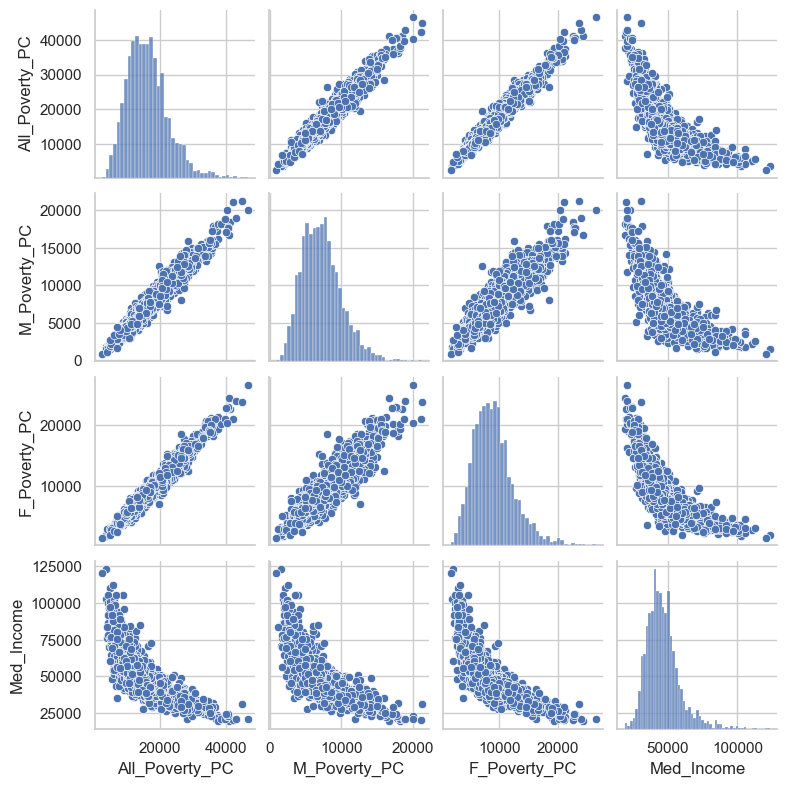

In [219]:
# Scatterplots (hat tip Sebastian Raschka from his book "Python Machine Learning")
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']], size=2)
plt.show()

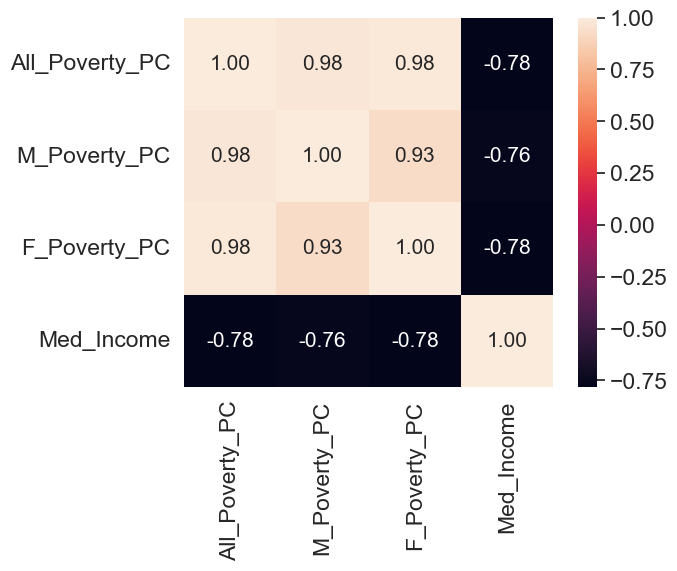

In [220]:
cols = ['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']
cm = np.corrcoef(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

All_Poverty_PC, F_Poverty_PC and M_Poverty_PC have high correlation. Therefore, we drop M_Poverty_PC and F_Poverty_PC and keep only All_Poverty_PC to represent poverty information in our model

In [221]:
X.drop(['M_Poverty_PC', 'F_Poverty_PC'], axis=1, inplace=True)

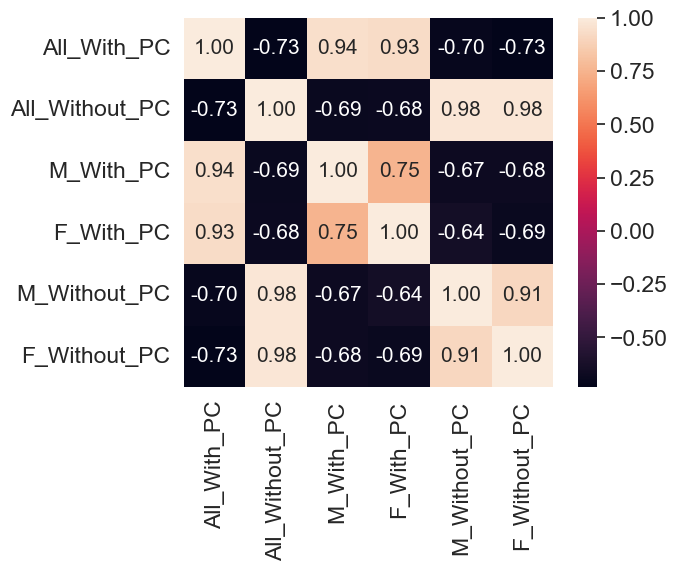

In [222]:
cols = ['All_With_PC', 'All_Without_PC', 'M_With_PC', 'F_With_PC', 'M_Without_PC', 'F_Without_PC']
cm = np.corrcoef(X[['All_With_PC', 'All_Without_PC', 'M_With_PC', 'F_With_PC', 'M_Without_PC', 'F_Without_PC']].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

After repeating this process with our health insurance variables, it became clear that the gender-specific features are redundant. After removing them, we're left with these data:

In [223]:
X.drop(['M_With_PC', 'F_With_PC'], axis=1, inplace=True)
X.drop(['M_Without_PC', 'F_Without_PC'], axis=1, inplace=True)
X.head()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Falling,Rising,POPESTIMATE2015,All_Poverty_PC,All_With_PC,All_Without_PC
2,23914,10698,13216,78326.0,120747,23245,122426,21393,243173,44638,61.5,0,0,298695,8006.160130,81411.808032,14944.341218
3,4364,2199,2165,51012.0,6396,2708,6627,1774,13023,4482,62.7,0,0,17946,24317.396634,72567.703109,24974.924774
7,7752,3523,4229,71068.0,40605,6957,40210,5322,80815,12279,58.1,0,0,99631,7780.710823,81114.311811,12324.477321
9,2110,1145,965,85746.0,13739,2433,13582,2213,27321,4646,35.1,0,0,32756,6441.567957,83407.619978,14183.661009
10,5558,2596,2962,63684.0,22391,6435,21668,5433,44059,11868,64.9,0,0,58059,9573.020548,75886.598116,20441.275254


#### Correlation with remaining features

c:\Users\Tran Duy Anh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


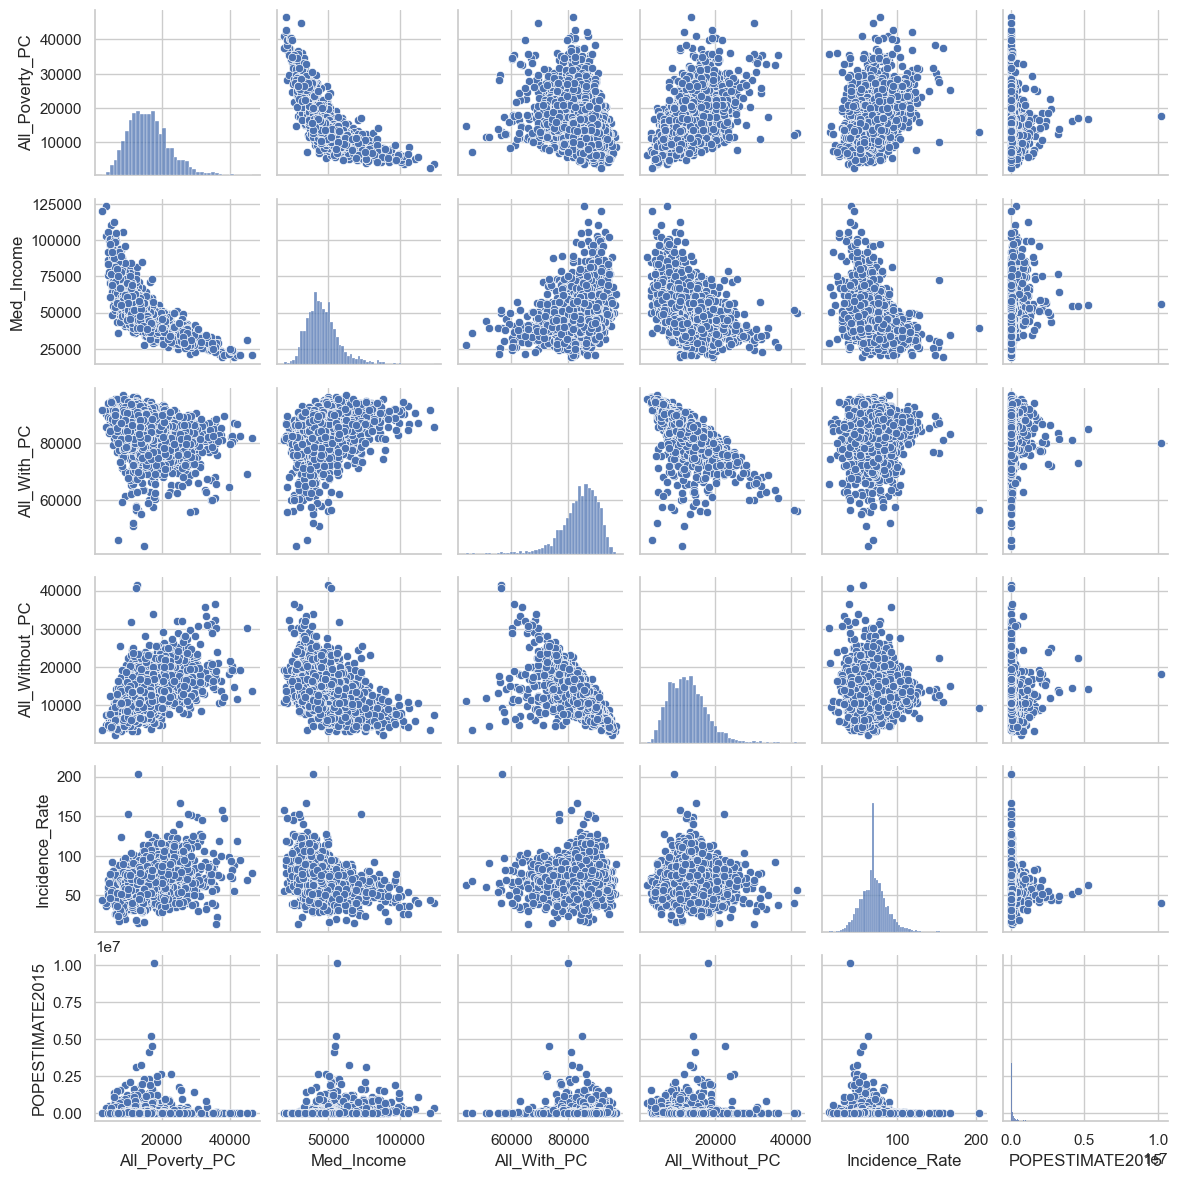

In [224]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
         'Incidence_Rate', 'POPESTIMATE2015']
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[cols], size=2)
plt.show()

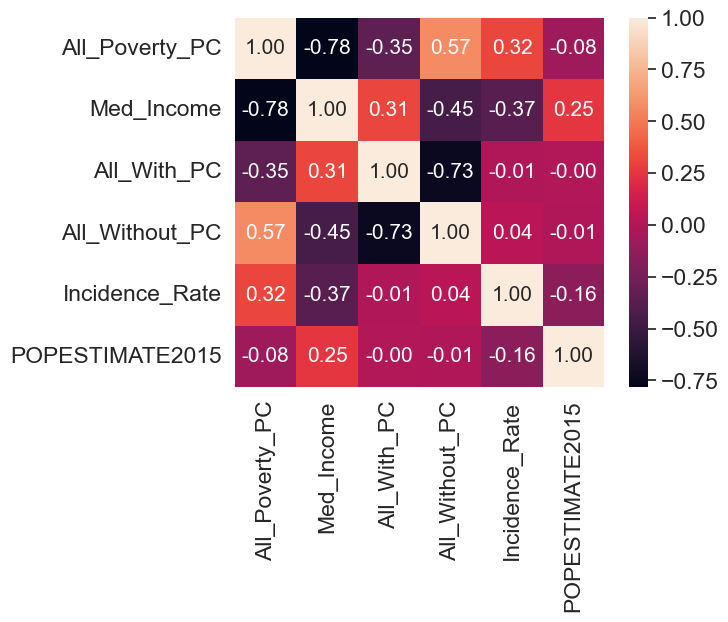

In [225]:
cm = np.corrcoef(X[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

There are a couple pairs of fairly strongly correlated features: (All_Poverty_PC & Med_Income) and (All_With_PC & All_Without_PC). Therefore we will observe how they work in the linear regression

# 3. Linear Regression Model

In [226]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC',  'All_Without_PC',
        'Incidence_Rate','POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty',
        'All_With', 'All_Without']

In [227]:
# Add constant (coloumn vector of all 1s)
X = X[cols]
X['Constant'] = 1
X.reset_index(drop=True, inplace=True)

# Fit linear regression model
lr = sm.OLS(y, X, hasconst=True)
result = lr.fit()

In [229]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     718.0
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        23:37:29   Log-Likelihood:                -9523.1
No. Observations:                2809   AIC:                         1.907e+04
Df Residuals:                    2797   BIC:                         1.914e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
All_Poverty_PC   9.517e-05   4.12e-05      2.308      0.021    1.43e-05       0.000
Med_Income         -0.0001   2.04e-05     -4.982      0.000      -0.000   -6.17e-05
All_With_PC      9.094e-06   3.33e-05      0.273      0.785   -5.61e-05    7.43e-05
All_Without_PC      0.0002   5.04e-05      4.310      0.000       0.000       0.000
Incidence_Rate      0.6517      0.009     73.756      0.000       0.634       0.669
POPESTIMATE2015 -4.224e-05   2.69e-05     -1.573      0.116   -9.49e-05    1.04e-05
Falling             1.2490      0.562      2.224      0.026       0.148       2.350
Rising             -1.0811      1.163     -0.929      0.353      -3.362       1.200
All_Poverty      -2.81e-05    1.3e-05     -2.167      0.030   -5.35e-05   -2.67e-06
All_With         4.428e-05   2.77e-05      1.600      0.110   -9.99e-06    9.86e-05
All_Without      5.714e-05   3.24e-05      1.762      0.078   -6.44e-06       0.000
Constant            7.2748      3.482      2.089      0.037       0.448      14.102
==============================================================================
Omnibus:                      306.600   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2334.415
Skew:                          -0.204   Prob(JB):                         0.00
Kurtosis:                       7.447   Cond. No.                     1.23e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After fitting an ordinary least squares model with the ['All_Poverty_PC', 'Med_Income', 'All_With_PC', All_Without_PC', 'Incidence_Rate', 'POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty', 'All_With', 'All_Without'] regressed on the Mortality_Rate target variable, we have a pretty well-performing model, as evidenced by the Adjusted R^2 (738).   
    
Let's treat this as our baseline, and apply model diagnostics and feature selection to try to improve it.   

We will attempt to account for multicollinearity, heteroscedsticity of residuals, and normality of distributions of residuals.     
       
#### Multicollinearity     
Let's apply variance inflation factors to assess for multicollinearity. VIFs, by performing an independent variable on the design matrix comprising all the other independent variables, allows us to assess the degree to which that independent variable is orthogonal the others. Larger VIFs indicate multicollinearity.     
**(!)note:** VIF values exceeding 10 are commonly interpreted as "high" in multicollinearity. However, this threshold is arbitrary, and it may make sense to select a different threshold in many cases.

In [230]:
pd.DataFrame([[var, variance_inflation_factor(X.values, X.columns.get_loc(var))] for var in X.columns],
                   index=range(X.shape[1]), columns=['Variable', 'VIF'])


,Variable,VIF
0,All_Poverty_PC,3.454206
1,Med_Income,3.490674
2,All_With_PC,2.433937
3,All_Without_PC,3.180459
4,Incidence_Rate,1.225081
5,POPESTIMATE2015,4692.901021
6,Falling,1.116247
7,Rising,1.005324
8,All_Poverty,30.052522
9,All_With,3342.491590


After iteratively removing the feature associated with the largest VIF and then recalculating VIFs, we result in these independent variables:

In [231]:
X.columns

Index(['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
       'Incidence_Rate', 'POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty',
       'All_With', 'All_Without', 'Constant'],
      dtype='object')

In [232]:
vcols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
        'Incidence_Rate', 'Falling', 'Constant']

In [233]:
Xvcols = X[vcols].reset_index(drop=True)
pd.DataFrame([[var, variance_inflation_factor(Xvcols.values, Xvcols.columns.get_loc(var))] for var in vcols],
                   index=range(len(vcols)), columns=['Variable', 'VIF'])

,Variable,VIF
0,All_Poverty_PC,3.173299
1,Med_Income,2.798626
2,All_With_PC,2.214296
3,All_Without_PC,2.923725
4,Incidence_Rate,1.206690
5,Falling,1.034333
6,Constant,605.996066


Interestingly, All_Without (men and women without health insurance), versus the same per capita (All_Without_PC) don't indicate high multicollinearity. I'm not sure what to make of that. In any case, I'm opting to remove All_Without from the model because I believe that it's more or less a proxy for population.
     
Let's recompute a linear regression on the reduced set of independent variables.

In [234]:
vcols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
         'Incidence_Rate', 'Falling', 'Constant']
Xvcols = X[vcols].reset_index(drop=True)
lr = sm.OLS(y, Xvcols, hasconst=True)
result = lr.fit()

In [235]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1304.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        23:37:29   Log-Likelihood:                -9534.7
No. Observations:                2809   AIC:                         1.908e+04
Df Residuals:                    2802   BIC:                         1.913e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
All_Poverty_PC  5.624e-05   3.97e-05      1.418      0.156   -2.15e-05       0.000
Med_Income        -0.0001   1.83e-05     -6.291      0.000      -0.000   -7.95e-05
All_With_PC     2.735e-05   3.18e-05      0.859      0.390   -3.51e-05    8.98e-05
All_Without_PC     0.0002   4.85e-05      4.954      0.000       0.000       0.000
Incidence_Rate     0.6563      0.009     74.597      0.000       0.639       0.674
Falling            0.6966      0.542      1.284      0.199      -0.367       1.760
Constant           6.2011      3.353      1.850      0.064      -0.373      12.775
==============================================================================
Omnibus:                      297.983   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2276.150
Skew:                          -0.169   Prob(JB):                         0.00
Kurtosis:                       7.397   Cond. No.                     2.44e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [236]:
Xvcols.drop(columns=['All_With_PC'], inplace=True)

# Build a linear regression model with the remaining variables
lr = sm.OLS(y, Xvcols, hasconst=True)
result = lr.fit()

# Print the summary of the model
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     1565.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        23:37:29   Log-Likelihood:                -9535.1
No. Observations:                2809   AIC:                         1.908e+04
Df Residuals:                    2803   BIC:                         1.912e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
All_Poverty_PC  6.113e-05   3.92e-05      1.558      0.119   -1.58e-05       0.000
Med_Income        -0.0001   1.83e-05     -6.244      0.000      -0.000   -7.83e-05
All_Without_PC     0.0002   3.51e-05      6.019      0.000       0.000       0.000
Incidence_Rate     0.6563      0.009     74.598      0.000       0.639       0.674
Falling            0.6976      0.542      1.286      0.199      -0.366       1.761
Constant           8.7399      1.584      5.519      0.000       5.635      11.845
==============================================================================
Omnibus:                      298.616   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2279.187
Skew:                          -0.172   Prob(JB):                         0.00
Kurtosis:                       7.399   Cond. No.                     6.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

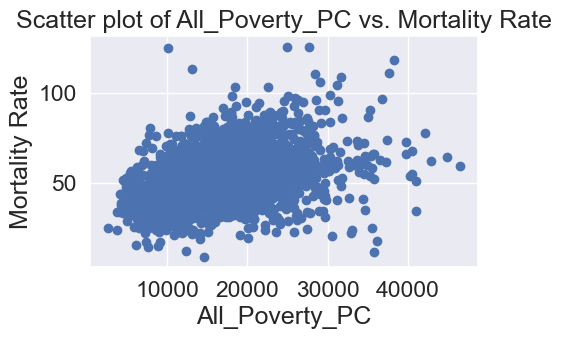

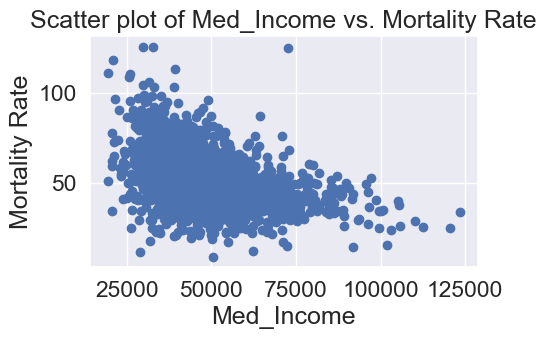

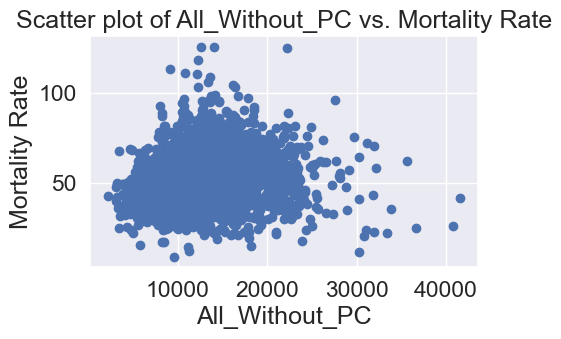

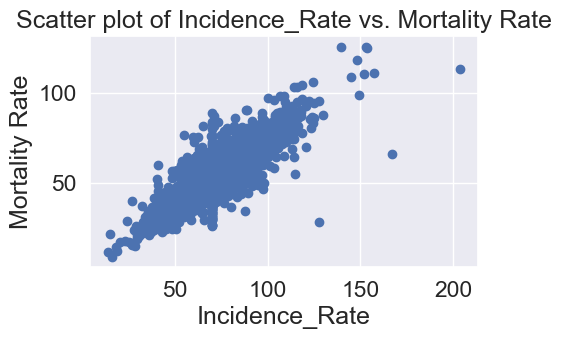

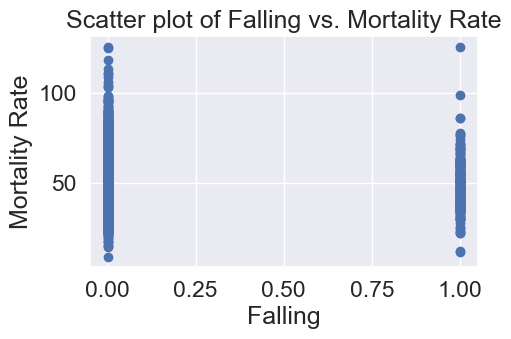

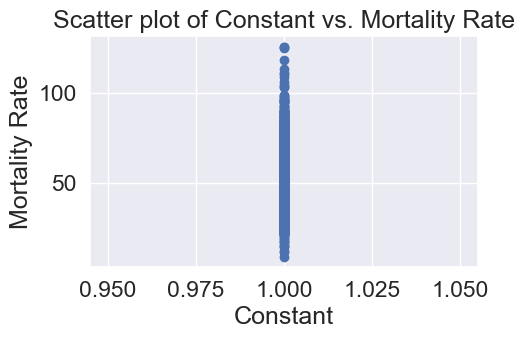

In [237]:
for col in Xvcols.columns:
    plt.figure(figsize=(5, 3))
    plt.scatter(Xvcols[col], y)
    plt.xlabel(col)
    plt.ylabel('Mortality Rate')
    plt.title(f'Scatter plot of {col} vs. Mortality Rate')
    plt.show()

In [238]:
# Turn Med_Income into log
Xvcols['Med_Income_log'] = np.log(Xvcols['Med_Income'])

# Delete the original column Med_Income
Xvcols.drop(columns=['Med_Income'], inplace=True)

# Add constant column
Xvcols = sm.add_constant(Xvcols)

# Fit the model again
lr = sm.OLS(y, Xvcols)
result = lr.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     1579.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        23:37:30   Log-Likelihood:                -9526.0
No. Observations:                2809   AIC:                         1.906e+04
Df Residuals:                    2803   BIC:                         1.910e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
All_Poverty_PC -3.186e-05   4.47e-05     -0.713      0.476      -0.000    5.57e-05
All_Without_PC     0.0002    3.5e-05      6.144      0.000       0.000       0.000
Incidence_Rate     0.6529      0.009     74.233      0.000       0.636       0.670
Falling            0.8279      0.541      1.530      0.126      -0.233       1.889
Constant          91.4433     12.106      7.554      0.000      67.706     115.180
Med_Income_log    -8.0541      1.062     -7.582      0.000     -10.137      -5.971
==============================================================================
Omnibus:                      299.943   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2276.955
Skew:                          -0.181   Prob(JB):                         0.00
Kurtosis:                       7.396   Cond. No.                     1.95e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [239]:
# Turn All_Poverty_PC into squared 
Xvcols['All_Poverty_PC_squared'] = Xvcols['All_Poverty_PC'] ** 2

# Delete the original column All_Poverty_PC 
Xvcols.drop(columns=['All_Poverty_PC'], inplace=True)

# Add constant column
Xvcols = sm.add_constant(Xvcols)

# Fit the model again
lr = sm.OLS(y, Xvcols)
result = lr.fit()
result.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     1581.
Date:                Fri, 10 May 2024   Prob (F-statistic):               0.00
Time:                        23:37:30   Log-Likelihood:                -9524.6
No. Observations:                2809   AIC:                         1.906e+04
Df Residuals:                    2803   BIC:                         1.910e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
All_Without_PC             0

This model looks satisfied. Specifically: 
1) VIFs indicate that it's not afflicted by multicollinearity
2) all the parameters are statistically significant (P>|t|)
3) all the parameters logically make sense (eg, oriented in directions that logically make sense)

### Breusch-Pagan Test

In [241]:
test_result = sms.het_breuschpagan(result.resid, result.model.exog)

In [242]:
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
lzip(names, test_result)

[('Lagrange multiplier statistic', 93.41005216319817),
 ('p-value', 1.2898701013275402e-18),
 ('f-value', 19.283351407454802),
 ('f p-value', 6.43327548829741e-19)]

#### Result: The model has homoscedasticity